In [1]:
import os

# Set CPU count for numpyro multi-chain multi-thread
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import pickle
import itertools

import jax
# Enable x64 for JAX
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as np
import jax.random as jr
from jax import jit, lax

import numpy as onp
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.io import fits
from scipy.ndimage import binary_dilation

from dLux.utils import arcsec2rad as toRad
from dLux.utils import rad2arcsec as toArcsec
from dLuxWebbpsf.utils import grid_search, get_pixel_positions
from dLuxWebbpsf import NIRCam
import zodiax as zdx

def norm(data):
    return data/data.sum()

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [2]:
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

In [3]:
def plot_residuals(a, b, title, points = None, text = None):
    fig = plt.figure(figsize=(12, 10))

    plt.suptitle(title)

    plt.subplot(2, 2, 1)

    plt.imshow(a)
    plt.colorbar()
    plt.title("Data")

    if (points is not None):
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")

    plt.subplot(2, 2, 2)

    plt.imshow(b)
    plt.colorbar()
    plt.title("Model")

    if (points is not None):
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")

    plt.subplot(2, 2, 3)
    plt.imshow(a - b)
    plt.colorbar()
    plt.title("Residual")

    if (points is not None):
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")
    
    residual = a - b
    rel_resid = residual / a**0.5

    plt.subplot(2, 2, 4)
    plt.imshow(rel_resid, vmin=-(np.nanmax(rel_resid)*2))
    plt.colorbar()
    plt.title("Relative residual ((data - model)/data**0.5)")
    
    if points is not None:
        for x, y, s in points:
            plt.plot(x, y, marker=s, color="red")

    if text is not None:
        plt.figtext(0.25, 0.01, text)

    plt.show()

### Get data from FITS files

In [4]:
def read_fits(path):
    hdul = fits.open(path)
    #hdul.info()

    webbpsf_header = hdul[0].header
    webbpsf_data_star = np.array(sum(hdul[1].data))
    webbpsf_data_err = np.array(sum(hdul[2].data))
    webbpsf_data_dq = np.array(sum(hdul[3].data))

    hdul.close()

    # cleanup data
    webbpsf_data_star = np.where(np.isnan(webbpsf_data_star), 0, webbpsf_data_star)

    npix_x = webbpsf_data_star.shape[0]
    npix_y = webbpsf_data_star.shape[1]
    xx, yy = np.array(np.meshgrid(np.arange(npix_x), np.arange(npix_y)))

    bri_y, bri_x = np.unravel_index(webbpsf_data_star.argmax(), webbpsf_data_star.shape)

    msize = 2
    mask_x = (xx >= (bri_x - msize)) & (xx <= (bri_x + msize))
    mask_y = (yy >= bri_y - msize) & (yy <= bri_y + msize)

    webbpsf_data_mask = np.where((mask_x & mask_y), 0, 1)
    webbpsf_data_mask = np.logical_not(binary_dilation(np.logical_not(webbpsf_data_mask))).astype(webbpsf_data_mask.dtype)
    webbpsf_data_mask *= (webbpsf_data_dq == 0) & ~((xx == 9) & (yy == 31)) # 9,31 is a hot pixel
    
    return webbpsf_header, webbpsf_data_star, webbpsf_data_mask, webbpsf_data_err

In [17]:
base_path = '../data/JWSTGO1902/calints_bpfixed/'
fits_file = base_path + 'jw01902002001_0210e_00001_nrcb1_calints_bpfixed.fits'


webbpsf_header, webbpsf_data_star, webbpsf_data_mask, webbpsf_data_err = read_fits(fits_file)

webbpsf_data = webbpsf_data_star * webbpsf_data_mask
webbpsf_data_norm = norm(webbpsf_data)

In [18]:
webbpsf_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2023-04-14T05:39:29.979' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw01902002001_0210e_00001_nrcb1_calints.fits' / Name of the file     
SDP_VER = '2022_5c '           / Data processing software version number        
PRD_VER = 'PRDOPSSOC-060'      / S&OC PRD version number used in data processing
OSS_VER = '008.005.000.000'    / Observatory Scheduling Software (OSS) version n
CAL_VER = '1.10.0  '        

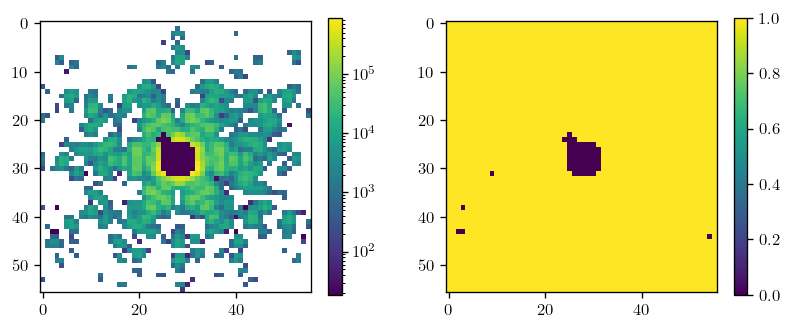

In [19]:
fig = plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(webbpsf_data, norm='log')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(webbpsf_data_mask)
plt.colorbar()

plt.show()

### Create model

In [24]:
webb_options = {
}

npix = webbpsf_data.shape[0]

flux = np.sum(webbpsf_data_star)
zernike_terms=3

telescope = NIRCam(
                filter = webbpsf_header['FILTER'],
                detector = webbpsf_header['DETECTOR'].replace('LONG', '5'),
                aperture = webbpsf_header['APERNAME'],
                fft_oversample=1,
                detector_oversample=4,
                wavefront_downsample=8,
                fov_pixels=npix,
                options=webb_options,
                phase_retrieval_terms = zernike_terms,
                load_opd_date=webbpsf_header['DATE-BEG']
               )


MAST OPD query around UTC: 2023-02-19T15:18:08.320
                        MJD: 59994.6375962963

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2023021903-NRCA3_FP1-1.fits
	Date (MJD):	 59994.0235
	Delta time:	 -0.6141 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2023022103-NRCA3_FP1-1.fits
	Date (MJD):	 59995.9079
	Delta time:	 1.2703 days
User requested choosing OPD time closest in time to 2023-02-19T15:18:08.320, which is R2023021903-NRCA3_FP1-1.fits, delta time -0.614 days
Importing and format-converting OPD from /Users/uqitroit/Dev/optics/webbpsf-data/MAST_JWST_WSS_OPDs/R2023021903-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


In [25]:
pixscale = toRad(telescope.psf_pixel_scale)

def toPix(value):
    ret = (value / pixscale) + npix/2 - 0.5
    return ret

## Step 2: Make an optical model for optimisation where source will be parametrised.

The solution that they have for this same problem in https://github.com/amerand/CANDID, a popular interferometry data analysis code, is to calculate the likelihood on a grid of xy with other parameters held constant, to identify the best position to start
see that page - scroll down to ‘CHI2MAP’ and ‘FITMAP’

In [26]:
@zdx.filter_jit
def likelihood(model, x, y, expected_data):
    model_data_n = model.set(['source.position'], [np.array([x, y])]).model()
    model_data = norm(model_data_n * webbpsf_data_mask)
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared
    return likelihood

@zdx.filter_jit
def likelihood_fast(model, x, y, expected_data):
    likelihood_c = lambda args : likelihood(model, args[0], args[1], expected_data)
    args = np.stack((x, y), axis=-1)
    return lax.map(likelihood_c, args)

In [27]:
def get_single(xr, yr):
    return likelihood_fast(telescope, xr, yr, webbpsf_data_norm)

_ = get_single(np.array([0]),np.array([0]))

CPU times: user 2min 19s, sys: 4.92 s, total: 2min 24s
Wall time: 32.5 s


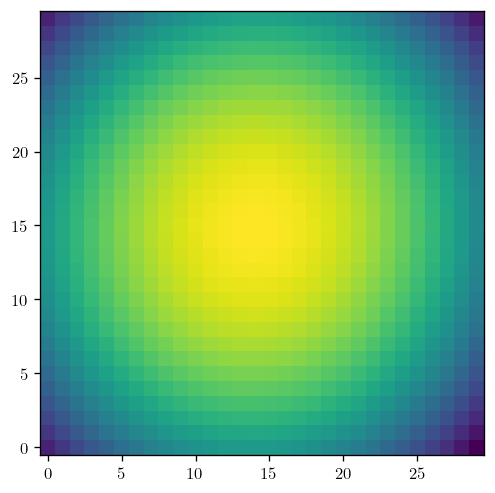

In [28]:
%%time

pri_width = toRad(1)
pri_xr, pri_yr, tp = grid_search(get_single, 0, 0, grid_size = pri_width, grid_steps = 30, niter = 10)
plt.imshow(tp[-1]['likelihoods'], origin='lower')

In [62]:
import webbpsf
import pysiaf

webb_osys = webbpsf.NIRCam()

webb_osys.filter = webbpsf_header['FILTER']
webb_osys.detector = webbpsf_header['DETECTOR'].replace('LONG', '5')

webb_osys.options['source_offset_x'] = toArcsec(pri_xr)
webb_osys.options['source_offset_y'] = -toArcsec(pri_yr)

# Siaf aperture
aper = pysiaf.Siaf(webb_osys.name)[webbpsf_header['APERNAME']]
webb_osys.set_position_from_aperture_name(webbpsf_header['APERNAME'])

webb_osys.load_wss_opd_by_date(webbpsf_header['DATE-BEG'])

data_h = webb_osys.calc_psf(oversample=4, fov_pixels=56)

print(webb_osys.pixelscale)


MAST OPD query around UTC: 2023-02-19T15:18:08.320
                        MJD: 59994.6375962963

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2023021903-NRCA3_FP1-1.fits
	Date (MJD):	 59994.0235
	Delta time:	 -0.6141 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2023022103-NRCA3_FP1-1.fits
	Date (MJD):	 59995.9079
	Delta time:	 1.2703 days
User requested choosing OPD time closest in time to 2023-02-19T15:18:08.320, which is R2023021903-NRCA3_FP1-1.fits, delta time -0.614 days
Importing and format-converting OPD from /Users/uqitroit/Dev/optics/webbpsf-data/MAST_JWST_WSS_OPDs/R2023021903-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
rotate_value : 0.4629549
0.03063267


In [68]:
data_h.info()

def likelihood_slow(data, expected_data):
    model_data = norm(data * webbpsf_data_mask)
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared
    return likelihood

likelihoods = []

for l in np.linspace(0.03020408, 0.03102041):
    webb_osys.pixelscale = l
    data_h = webb_osys.calc_psf(oversample=4, fov_pixels=56)
    recovered_data = data_h[3].data
    
    likelihood = likelihood_slow(recovered_data, webbpsf_data_norm)
    likelihoods.append((l, likelihood))


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     105   (224, 224)   float64   
  1  DET_SAMP      1 ImageHDU       107   (56, 56)   float64   
  2  OVERDIST      1 ImageHDU       154   (224, 224)   float64   
  3  DET_DIST      1 ImageHDU       160   (56, 56)   float64   
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rotate_value : 0.4629549
rota

In [69]:
likelihoods

[(Array(0.03020408, dtype=float64), Array(-0.00036771, dtype=float64)),
 (Array(0.03022074, dtype=float64), Array(-0.00036697, dtype=float64)),
 (Array(0.0302374, dtype=float64), Array(-0.00036628, dtype=float64)),
 (Array(0.03025406, dtype=float64), Array(-0.00036563, dtype=float64)),
 (Array(0.03027072, dtype=float64), Array(-0.00036502, dtype=float64)),
 (Array(0.03028738, dtype=float64), Array(-0.00036446, dtype=float64)),
 (Array(0.03030404, dtype=float64), Array(-0.00036395, dtype=float64)),
 (Array(0.0303207, dtype=float64), Array(-0.00036348, dtype=float64)),
 (Array(0.03033736, dtype=float64), Array(-0.00036305, dtype=float64)),
 (Array(0.03035402, dtype=float64), Array(-0.00036267, dtype=float64)),
 (Array(0.03037068, dtype=float64), Array(-0.00036234, dtype=float64)),
 (Array(0.03038734, dtype=float64), Array(-0.00036204, dtype=float64)),
 (Array(0.030404, dtype=float64), Array(-0.0003618, dtype=float64)),
 (Array(0.03042066, dtype=float64), Array(-0.00036159, dtype=float64)

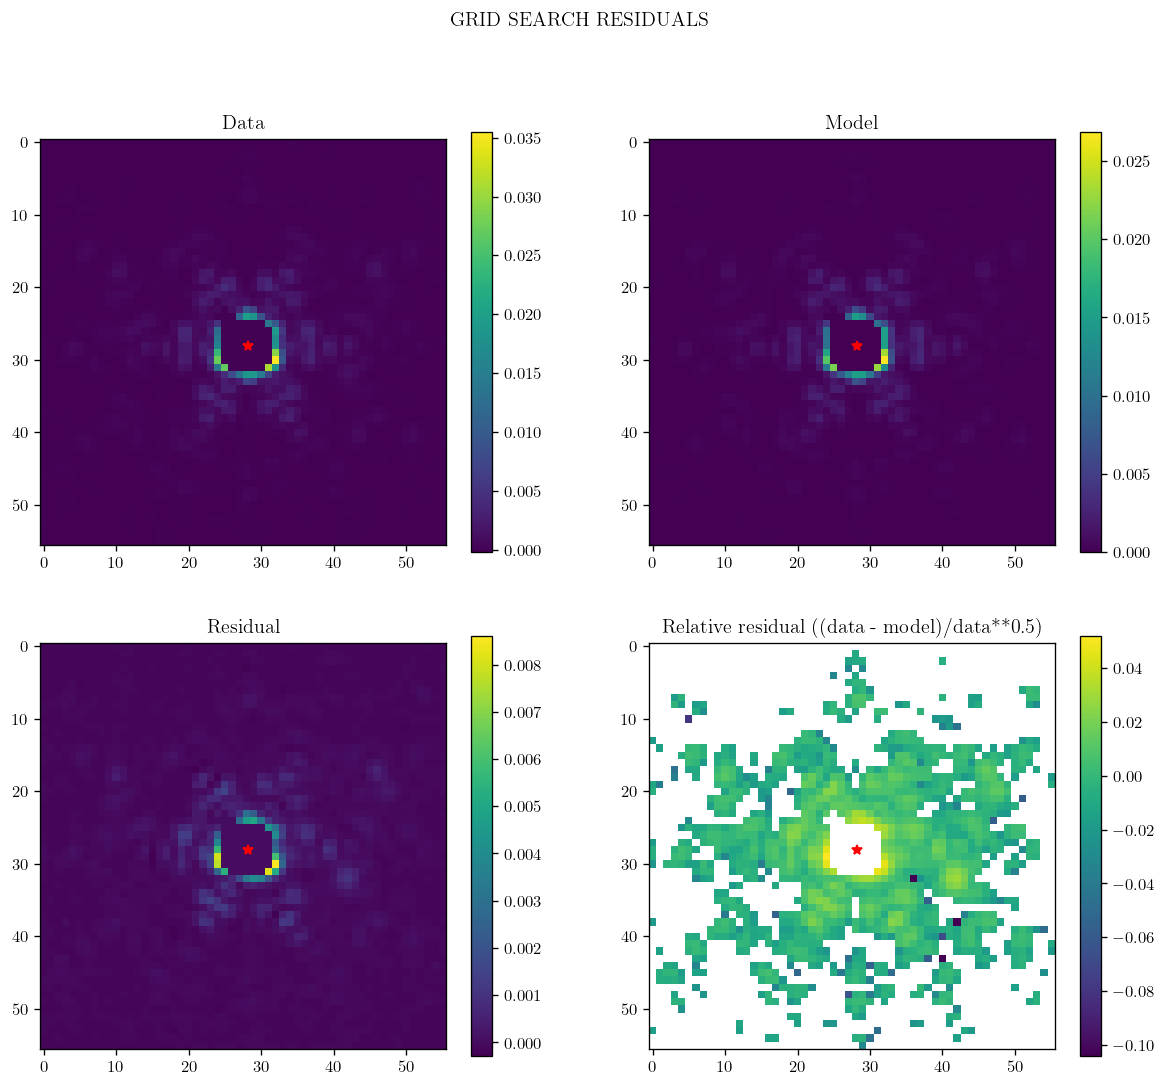

In [64]:
#recovered_data = telescope.set(['source.position'], [np.array([pri_xr, pri_yr])]).model()

plot_residuals(webbpsf_data_norm, norm(recovered_data*webbpsf_data_mask),
               "GRID SEARCH RESIDUALS",
               points = [(toPix(pri_xr), toPix(-pri_yr), '*')])

## Step 3: Set up HMC parameters and distributions.

In [87]:
std = np.sqrt(webbpsf_data_err * webbpsf_data_mask).flatten()
std = np.where((std == 0) | np.isnan(std), np.nanmean(std), std)

coord_range = toArcsec(1 * pixscale)
log_flux_range = 3

x0 = toArcsec(pri_xr)
y0 = toArcsec(pri_yr)

flux = np.sum(webbpsf_data_star)
log_flux = np.log(flux)

print(log_flux)

17.666492


In [88]:
coord_range

0.06241982

In [89]:
import numpyro as npy
import numpyro.distributions as dist

parameters = ['source.position', 'pupil.coefficients', 'source.flux']

n_mirrors = 18
n_coeffs = n_mirrors * zernike_terms

phase_scale = 1e-6

fixed_mirrors = {
    (0,0): 0,
    (1,0): 0,
    (2,0): 0,
}

def psf_model(data, data_err, model):
    """
    Define the numpyro function
    """
    
    x_sample = npy.sample("x_arcsec", dist.Uniform(x0 - coord_range, x0 + coord_range))
    y_sample = npy.sample("y_arcsec", dist.Uniform(y0 - coord_range, y0 + coord_range))
    
    phases_data = [0] * n_coeffs
    for i, z in itertools.product(range(n_mirrors), range(zernike_terms)):
        coeff_index = i*zernike_terms + z
        if (z, i) in fixed_mirrors:
            phases_data[coeff_index] = fixed_mirrors[(z,i)]
        else:
            sample = npy.sample(f'p{coeff_index}', dist.Uniform(-1,1))
            phases_data[coeff_index] = sample * phase_scale
                              
    flux_sample  = npy.sample("log_flux", dist.Uniform(log_flux - log_flux_range, log_flux + log_flux_range))
    det_flux = np.exp(flux_sample)
    
    det_x = toRad(x_sample)
    det_y = toRad(y_sample)
    
    values = [
        np.array([det_x, det_y]),
        np.array(phases_data),
        det_flux
    ]
    
    with npy.plate("data", len(data.flatten())):
        model_data = (model.set(parameters, values).model() * webbpsf_data_mask).flatten()
        #model_data = norm(model_data)
        
        dist_model = dist.Normal(model_data, data_err)
        npy.sample("psf", dist_model, obs=data.flatten())
        

In [ ]:
from jax import device_count

initial_values = {
    "x_arcsec": x0,
    "y_arcsec": y0,
    "log_flux": np.float64(log_flux)
}

for z, i in itertools.product(range(zernike_terms), range(n_mirrors)):
    if (z, i) not in fixed_mirrors:
        initial_values[f'p{i*zernike_terms + z}'] = 0

sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model, init_strategy=npy.infer.init_to_value(values=initial_values), dense_mass=True),
    num_warmup=1500,
    num_samples=1500,
    num_chains=device_count(),
    progress_bar=True
)
%time sampler.run(jr.PRNGKey(0), data_n, std, telescope)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

## Step 4: Make plots.

In [55]:
pickle_dir = "./pickles/"
os.makedirs(pickle_dir, exist_ok=True)

pickle_file = os.path.splitext(os.path.basename(webbpsf_header["FILENAME"]))[0] + ".bin"
pickle_path = os.path.join(pickle_dir, pickle_file)

In [56]:
#with open(pickle_path, "rb") as f:
#    values_out = pickle.load(f)

sampler.print_summary()
values_out = sampler.get_samples()

with open(pickle_path, "wb") as f:
    pickle.dump(values_out, f)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  log_flux     18.78      0.00     18.78     18.78     18.78   4838.29      1.00
       p10      0.01      0.00      0.01      0.01      0.01    891.29      1.00
       p11     -0.00      0.00     -0.00     -0.00     -0.00    751.70      1.01
       p12     -0.04      0.00     -0.04     -0.04     -0.04    643.24      1.01
       p13      0.00      0.00      0.00      0.00      0.00   1151.01      1.00
       p14      0.01      0.00      0.01      0.01      0.01    974.36      1.01
       p15     -0.04      0.00     -0.04     -0.04     -0.04    694.60      1.01
       p16      0.01      0.00      0.01      0.01      0.01   1564.51      1.00
       p17      0.00      0.00      0.00      0.00      0.00    962.02      1.01
       p18      0.01      0.00      0.01      0.01      0.01    681.55      1.01
       p19      0.02      0.00      0.02      0.02      0.02   1205.91      1.00
       p20     -0.00      0

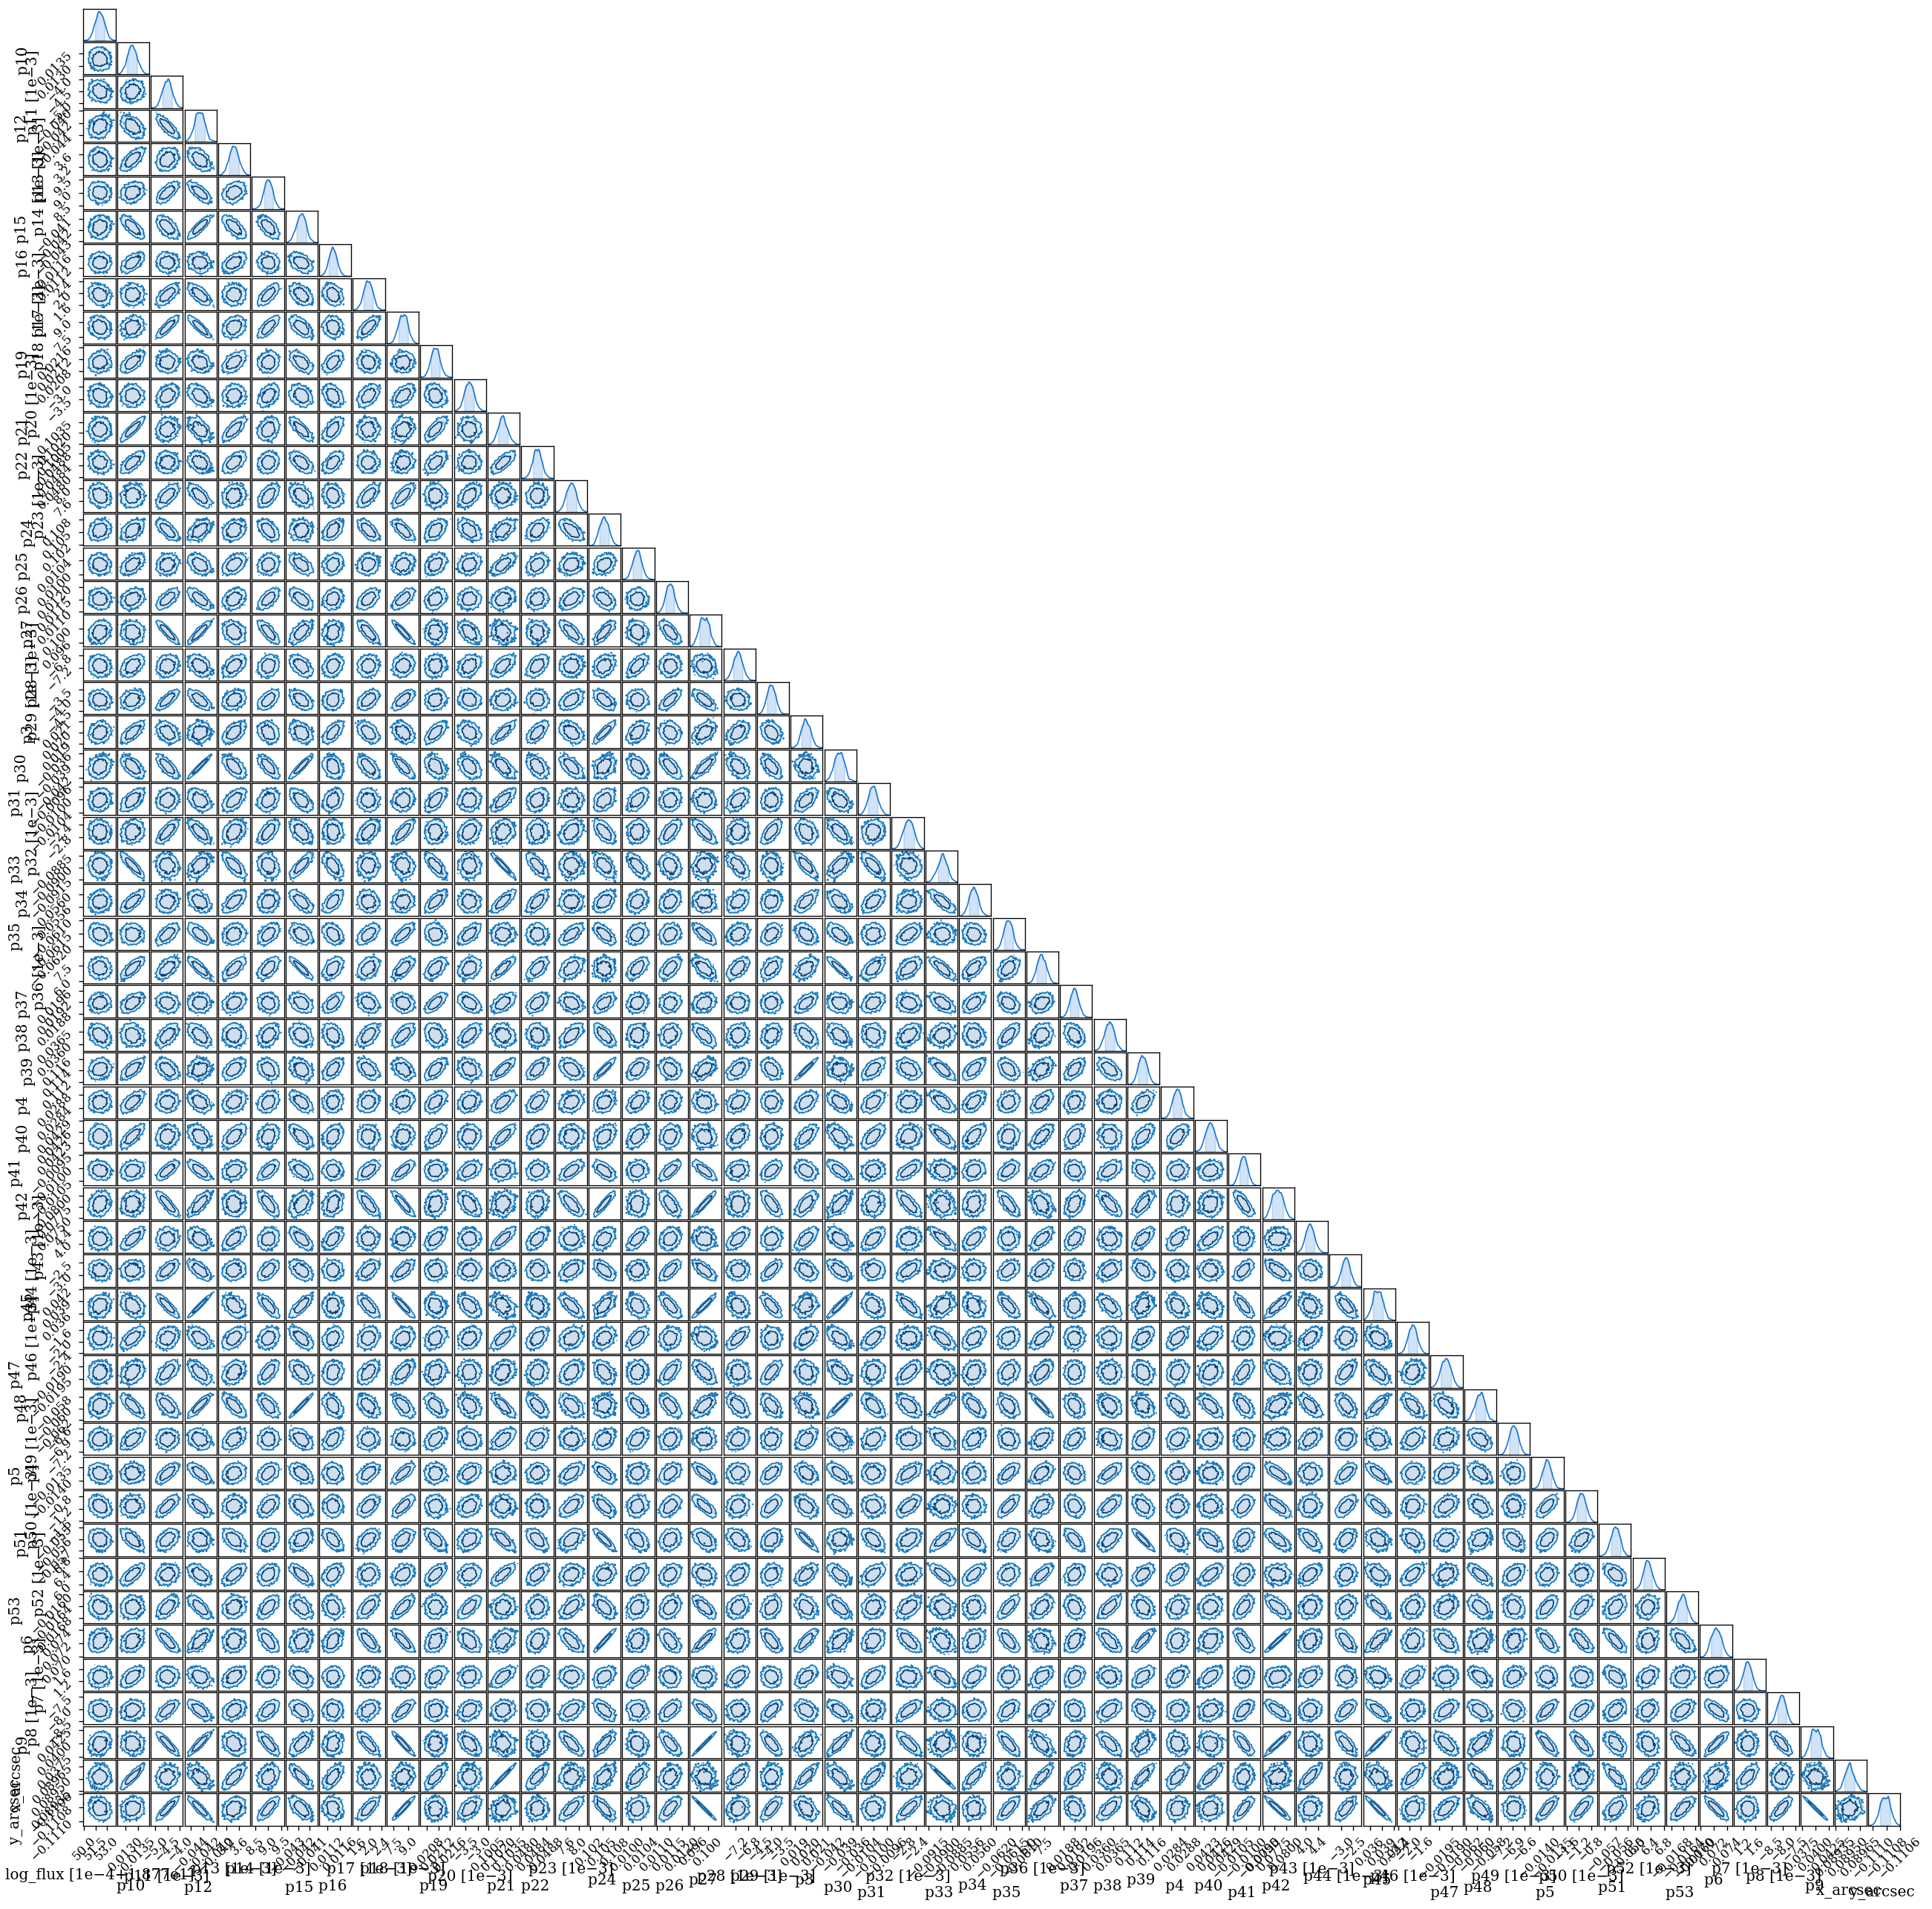

In [57]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure_truth(color='r', ls=":", alpha=0.8)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((24, 24));

In [58]:
#values_small = {k: values_out[k] for k in ('x_arcsec', 'y_arcsec', 'log_flux')}

#chain = cc.ChainConsumer()
#chain.add_chain(values_small)
#chain.configure_truth(color='r', ls=":", alpha=0.8)
#chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

#fig = chain.plotter.plot()
#fig.set_size_inches((12, 12));

In [59]:
#import arviz as az
#az.plot_trace(az.from_numpyro(sampler))

In [60]:
mean_vals = {k: np.mean(v) for k, v in values_out.items()}

x_predicted = toRad(mean_vals["x_arcsec"])
y_predicted = toRad(mean_vals["y_arcsec"])
flux_predicted = np.exp(mean_vals["log_flux"])

coeffs_pred_all = [0] * n_coeffs
for i, z in itertools.product(range(n_mirrors), range(zernike_terms)):
    coeff_index = i*zernike_terms + z
    if (z, i) in fixed_mirrors:
        coeffs_pred_all[coeff_index] = fixed_mirrors[(z,i)]
    else:
        coeffs_pred_all[coeff_index] = mean_vals[f'p{coeff_index}'] * phase_scale

coeffs_pred_all = np.array(coeffs_pred_all)

In [61]:
values_found = [
    np.array([x_predicted, y_predicted]),
    coeffs_pred_all,
    flux_predicted
]

params_found = [
    'source.position',
    'pupil.coefficients',
    'source.flux'
]

psf_found = model.set(params_found, values_found).model() * webbpsf_data_mask

Text(0.5, 1.0, 'Residual')

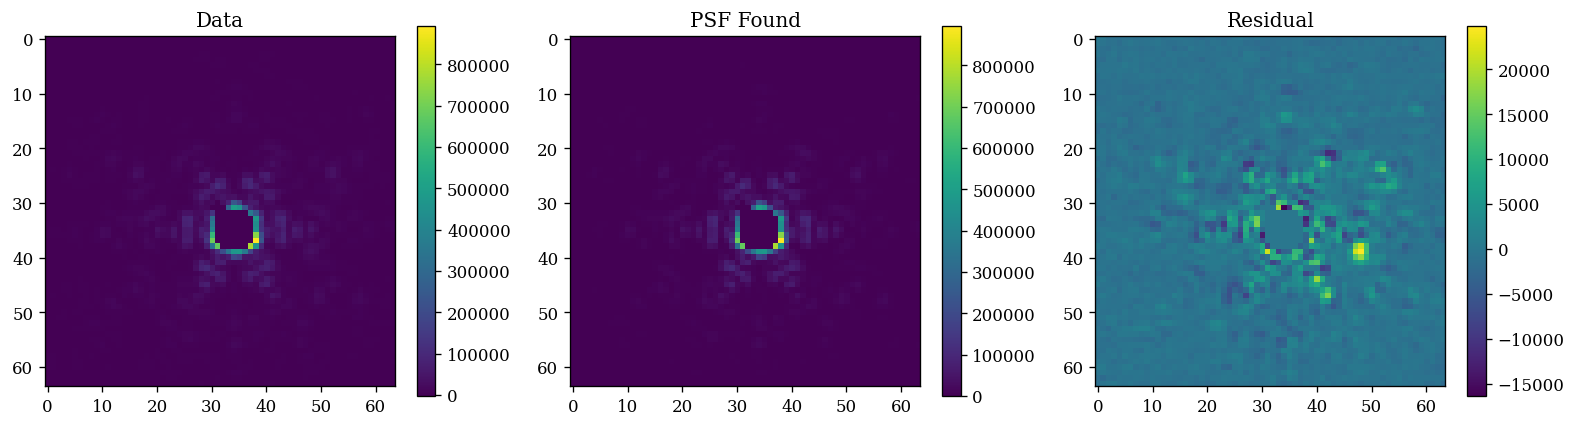

In [62]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)

plt.imshow(data_n)
plt.colorbar()
plt.title("Data")

plt.subplot(1, 3, 2)

plt.imshow(psf_found)
plt.colorbar()
plt.title("PSF Found")
plt.subplot(1, 3, 3)

plt.imshow(data_n - psf_found)
plt.colorbar()
plt.title("Residual")

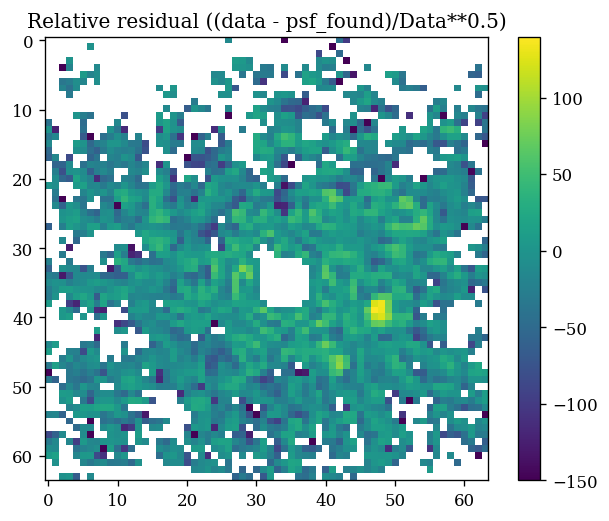

In [63]:
residual = data_n - psf_found
rel_resid = residual / data_n**0.5

plt.imshow(rel_resid, vmin=-150)
plt.colorbar()
plt.title("Relative residual ((data - psf_found)/Data**0.5)")
plt.show()

In [64]:
def get_aber(coeffs, basis):
    s_coeffs = np.asarray(coeffs.reshape(coeffs.shape[0], 1, 1), dtype=float)
    s_basis = np.asarray(basis, dtype=float)
    result = s_coeffs * s_basis
    return result.sum(0)

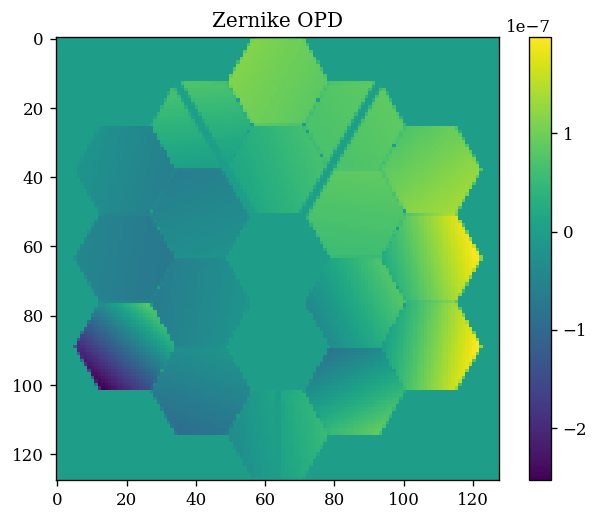

In [65]:
rec_aberrations = get_aber(coeffs_pred_all, telescope.pupil.basis)

plt.title("Zernike OPD")
plt.imshow((rec_aberrations)*telescope.pupil.transmission)

plt.colorbar()